In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import xgboost as xgb
from sklearn import model_selection, preprocessing
color = sns.color_palette()
%matplotlib inline

def num2log(arr):
    return np.log(arr + 1)
# result retransform
def log2num(arr):
    return np.exp(arr) - 1
# treat date
def trans_date(arr): 
    return datetime.datetime.strptime(arr, '%Y-%m-%d').date()

data = pd.read_csv('C:/Users/JP/Documents/School/Practicum/Github/Practicum/data/dataset.csv')

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
df = df.set_index('Date')
df=df[df.index>'2017-05-30']
df.head()

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,ETHOpen,ETHHigh,ETHLow,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue
Date,,,,,,,,,,
2017-05-31,228.58,233.92,214.05,154.68750,97.135,2.200,4.3,0.83,18569.1,2411.0
2017-05-31,228.58,233.92,214.05,154.68750,97.135,1.872,4.3,0.83,18569.1,2411.0
2017-06-01,228.64,235.52,208.00,154.96875,96.740,1.872,4.3,0.91,18569.1,2413.1
2017-06-01,228.64,235.52,208.00,154.96875,96.740,1.872,4.4,0.91,18569.1,2413.1
2017-06-02,220.70,227.71,216.94,154.90625,96.960,1.872,4.4,0.91,18569.1,2429.6


In [4]:
train_df = df[df.index<'2017-09-01']

train_df.head()

,ETHOpen,ETHHigh,ETHLow,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue
Date,,,,,,,,,,
2017-05-31,228.58,233.92,214.05,154.68750,97.135,2.200,4.3,0.83,18569.1,2411.0
2017-05-31,228.58,233.92,214.05,154.68750,97.135,1.872,4.3,0.83,18569.1,2411.0
2017-06-01,228.64,235.52,208.00,154.96875,96.740,1.872,4.3,0.91,18569.1,2413.1
2017-06-01,228.64,235.52,208.00,154.96875,96.740,1.872,4.4,0.91,18569.1,2413.1
2017-06-02,220.70,227.71,216.94,154.90625,96.960,1.872,4.4,0.91,18569.1,2429.6


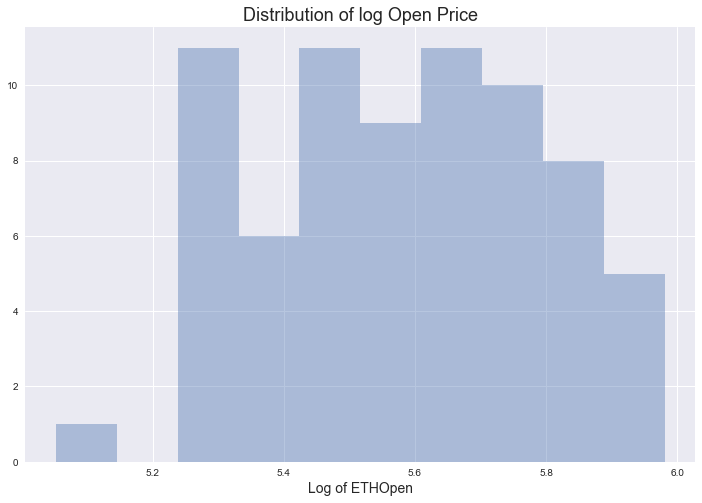

In [5]:
plt.figure(figsize=(12,8))
sns.distplot(num2log(train_df.ETHOpen.values), bins=10, kde=False)
plt.xlabel('Log of ETHOpen', fontsize=14)
plt.title('Distribution of log Open Price', fontsize = 18)
plt.show()

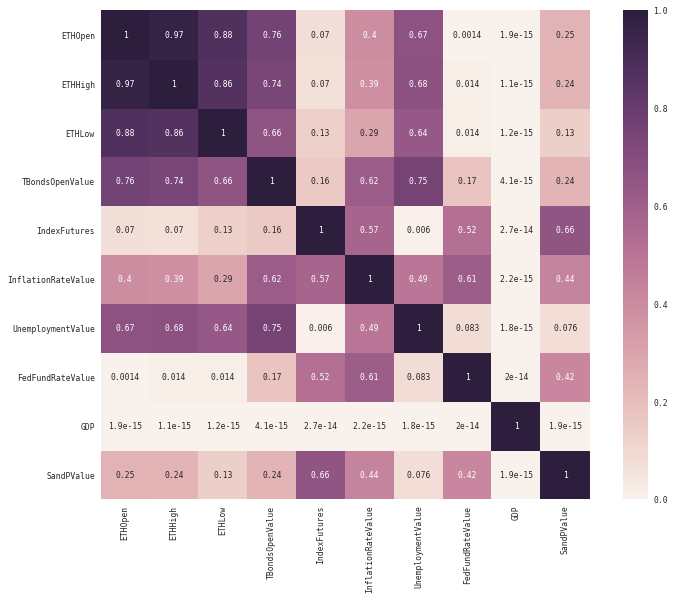

In [7]:
corrmat = train_df.corr(method='pearson')
corrmat = np.abs(corrmat)
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1,annot=True, square=True, xticklabels = True, yticklabels = True, 
            annot_kws={'size': 8})

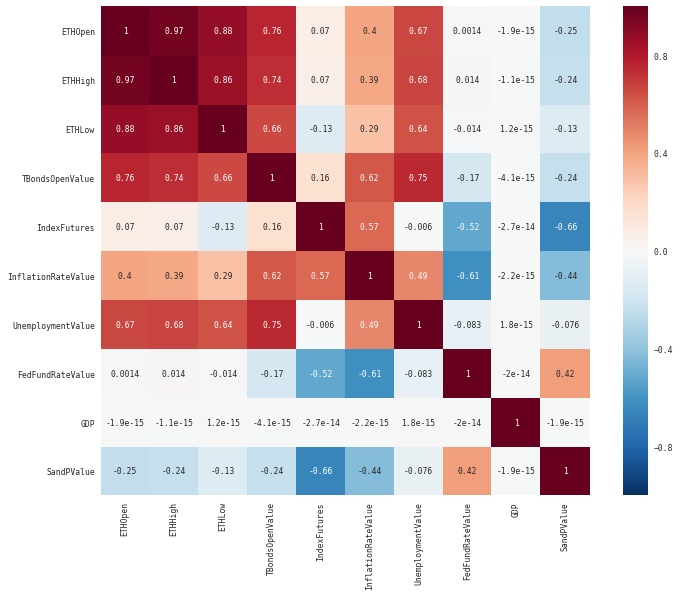

In [9]:
corrmat = train_df.corr(method='pearson')

sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1,vmin=-1,annot=True, square=True, xticklabels = True, yticklabels = True, 
            annot_kws={'size': 8})

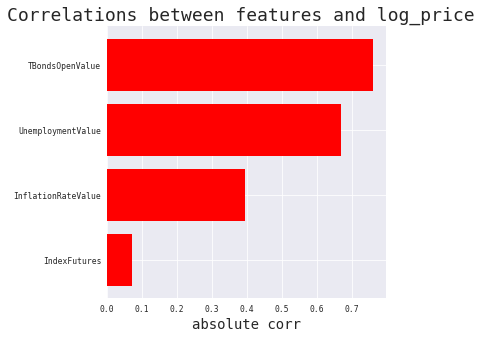

In [10]:
remain_num = 10
#train_df['logETHOpen'] = num2log(train_df.ETHOpen.values)
corr_target = corrmat['ETHOpen'].reset_index()[3:]
corr_target.columns = ['feature','abs_corr']
corr_target = corr_target.sort_values(by = 'abs_corr', ascending = True)[:remain_num].loc[corr_target['abs_corr'] >0.01]
ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(5,5))
rects = ax.barh(ind, corr_target.abs_corr.values, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("absolute corr", fontsize = 14)
ax.set_title("Correlations between features and log_price ", fontsize = 18)
plt.show()


In [12]:
df.tail()

,ETHOpen,ETHHigh,ETHLow,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue
Date,,,,,,,,,,
2017-09-25,282.60,297.01,282.48,154.25000,91.890,1.939,4.4,1.16,18569.1,2502.9
2017-09-26,294.89,295.89,287.01,154.84375,92.175,1.939,4.4,1.16,18569.1,2496.1
2017-09-27,288.64,312.64,287.83,154.65625,92.675,1.939,4.4,1.16,18569.1,2495.1
2017-09-28,309.97,310.24,298.18,152.90625,93.000,1.939,4.4,1.16,18569.1,2502.8
2017-09-29,302.77,303.54,279.79,152.75000,92.755,1.939,4.4,1.06,18569.1,2507.0


In [13]:
import json
import requests
import pandas as pd

from pandas.io.json import json_normalize



response = requests.get("https://min-api.cryptocompare.com/data/histoday?fsym=ETH&tsym=USD&allData=TRUE")


data = json.loads(response.text)
data2 = json_normalize(data)
json_data = data['Data']
df2=pd.DataFrame(data['Data'])
df2['time'] = pd.to_datetime(df2['time'],unit='s')
df2['Date'] = pd.to_datetime(df2['time'],unit='s')
BTC = df2[['Date','open']]
BTC['BTCOpen']=BTC['open']
BTC=BTC[['Date','BTCOpen']]
BTC.tail()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Date,BTCOpen
792,2017-10-07,308.33
793,2017-10-08,311.26
794,2017-10-09,309.49
795,2017-10-10,296.95
796,2017-10-11,298.46


In [71]:
df=df[df.index>'2017-05-30']
df['Date'] = df.index.values
dataset = pd.merge(df, BTC, on='Date')
dataset.tail()

,ETHOpen,ETHHigh,ETHLow,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue,Date,BTCOpen
87,282.60,297.01,282.48,154.25000,91.890,1.939,4.4,1.16,18569.1,2502.9,2017-09-25,282.60
88,294.89,295.89,287.01,154.84375,92.175,1.939,4.4,1.16,18569.1,2496.1,2017-09-26,294.89
89,288.64,312.64,287.83,154.65625,92.675,1.939,4.4,1.16,18569.1,2495.1,2017-09-27,288.64
90,309.97,310.24,298.18,152.90625,93.000,1.939,4.4,1.16,18569.1,2502.8,2017-09-28,309.97
91,302.77,303.54,279.79,152.75000,92.755,1.939,4.4,1.06,18569.1,2507.0,2017-09-29,302.77


In [72]:
dataset['ETHOpenTM1'] = dataset['ETHOpen'].shift(-1)
dataset['ETHOpenTM2'] = dataset['ETHOpen'].shift(-2)
dataset['ETHOpenTM3'] = dataset['ETHOpen'].shift(-3)
dataset['ETHOpenTM4'] = dataset['ETHOpen'].shift(-4)
dataset['ETHOpenTM5'] = dataset['ETHOpen'].shift(-5)
dataset['ETHOpenTM6'] = dataset['ETHOpen'].shift(-6)
dataset['ETHOpenTM7'] = dataset['ETHOpen'].shift(-7)
dataset['BTCOpenTM1'] = dataset['BTCOpen'].shift(-1)
dataset['BTCOpenTM2'] = dataset['BTCOpen'].shift(-2)
dataset['BTCOpenTM3'] = dataset['BTCOpen'].shift(-3)
dataset['BTCOpenTM4'] = dataset['BTCOpen'].shift(-4)
dataset['BTCOpenTM5'] = dataset['BTCOpen'].shift(-5)
dataset['BTCOpenTM6'] = dataset['BTCOpen'].shift(-6)
dataset['BTCOpenTM7'] = dataset['BTCOpen'].shift(-7)
dataset.head()

,ETHOpen,ETHHigh,ETHLow,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue,...,ETHOpenTM5,ETHOpenTM6,ETHOpenTM7,BTCOpenTM1,BTCOpenTM2,BTCOpenTM3,BTCOpenTM4,BTCOpenTM5,BTCOpenTM6,BTCOpenTM7
0,228.58,233.92,214.05,154.68750,97.135,2.200,4.3,0.83,18569.1,2411.0,...,244.96,247.75,264.26,228.58,228.64,228.64,220.70,244.96,247.75,264.26
1,228.58,233.92,214.05,154.68750,97.135,1.872,4.3,0.83,18569.1,2411.0,...,247.75,264.26,255.77,228.64,228.64,220.70,244.96,247.75,264.26,255.77
2,228.64,235.52,208.00,154.96875,96.740,1.872,4.3,0.91,18569.1,2413.1,...,264.26,255.77,259.41,228.64,220.70,244.96,247.75,264.26,255.77,259.41
3,228.64,235.52,208.00,154.96875,96.740,1.872,4.4,0.91,18569.1,2413.1,...,255.77,259.41,339.68,220.70,244.96,247.75,264.26,255.77,259.41,339.68
4,220.70,227.71,216.94,154.90625,96.960,1.872,4.4,0.91,18569.1,2429.6,...,259.41,339.68,394.66,244.96,247.75,264.26,255.77,259.41,339.68,394.66


In [151]:
dataset.to_csv('C:/Users/JP/Documents/School/Practicum/Github/Practicum/data/dataset2.csv',index=False)


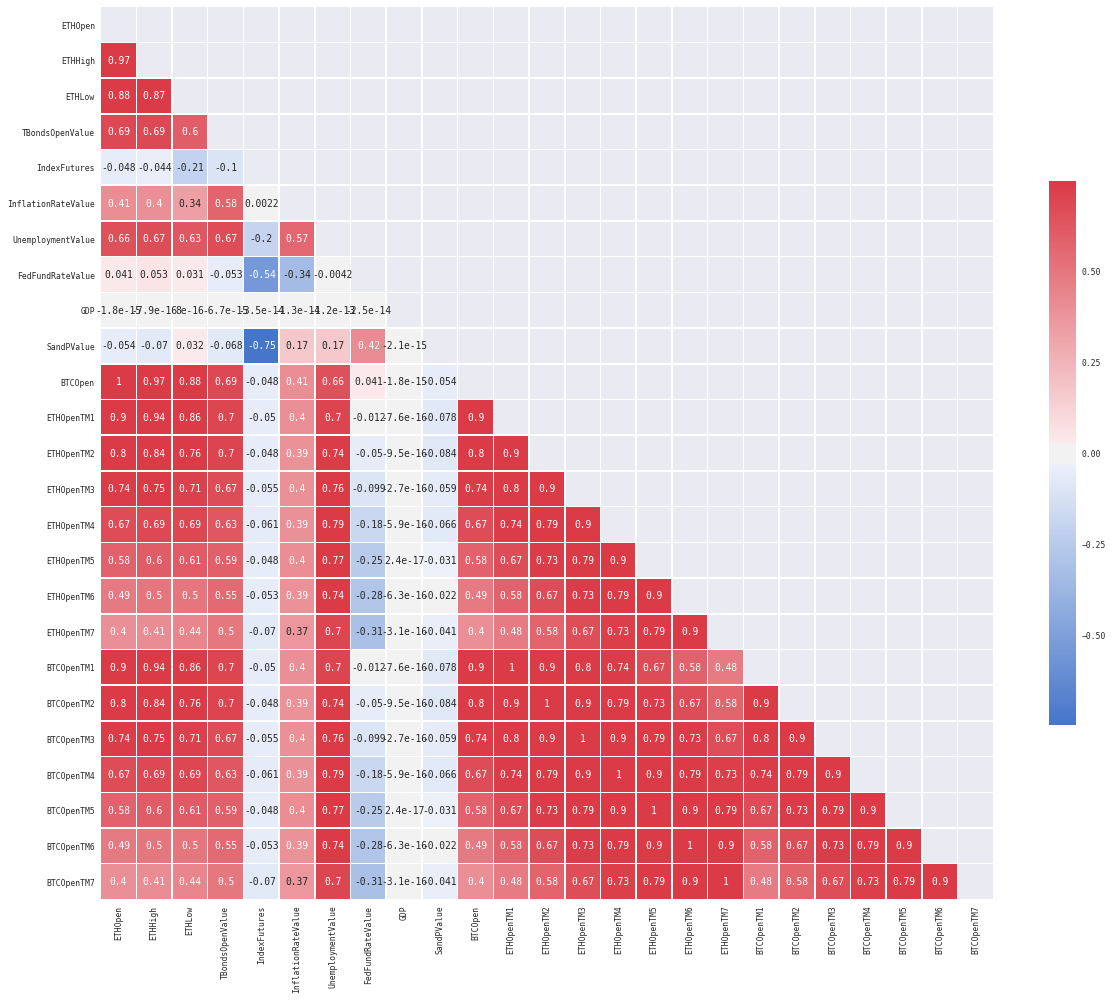

In [16]:
corr = dataset.corr(method='pearson')
#corrmat = np.abs(corrmat)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True



cmap = sns.diverging_palette(255, 10, as_cmap=True)

f, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,xticklabels = True, yticklabels = True, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

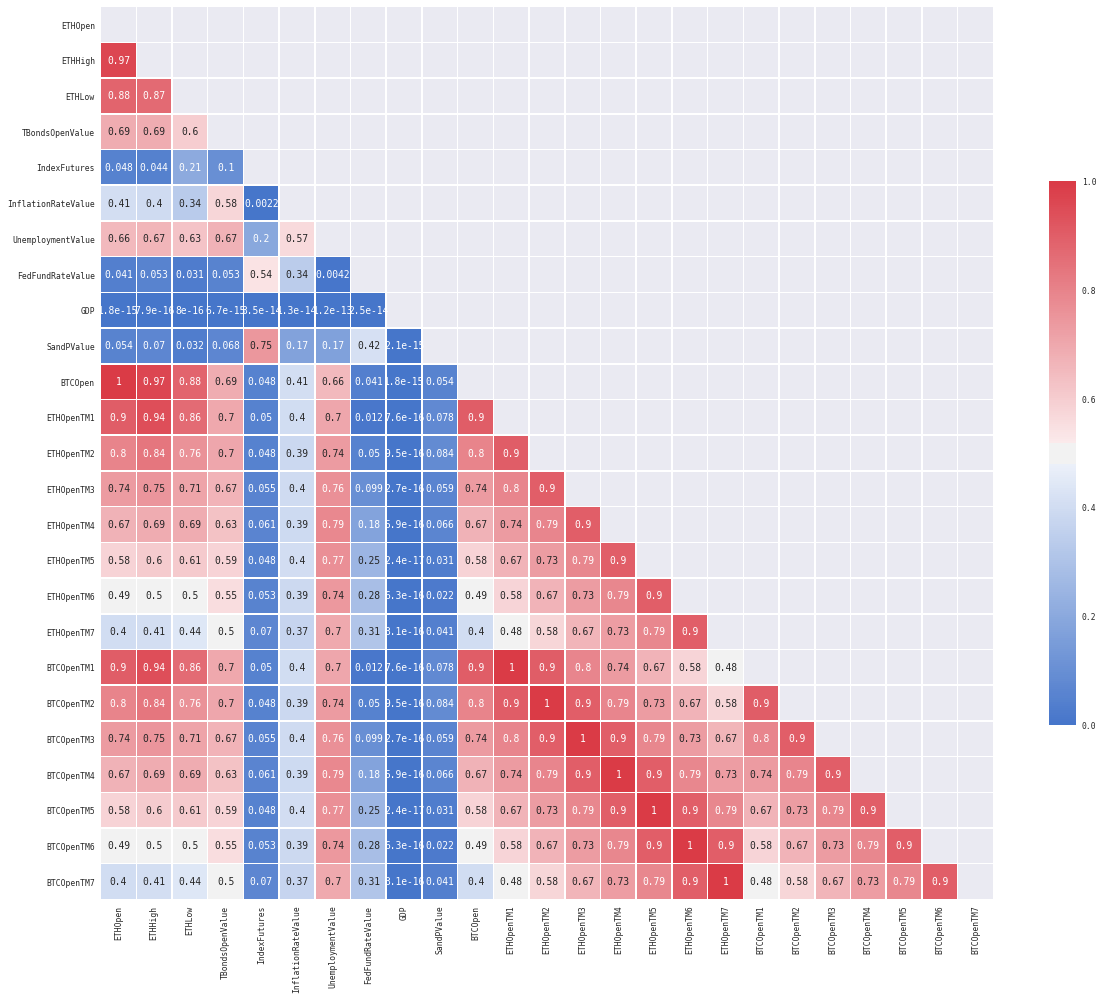

In [17]:
corr = dataset.corr(method='pearson')
corr = np.abs(corr)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=.5,xticklabels = True, yticklabels = True, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

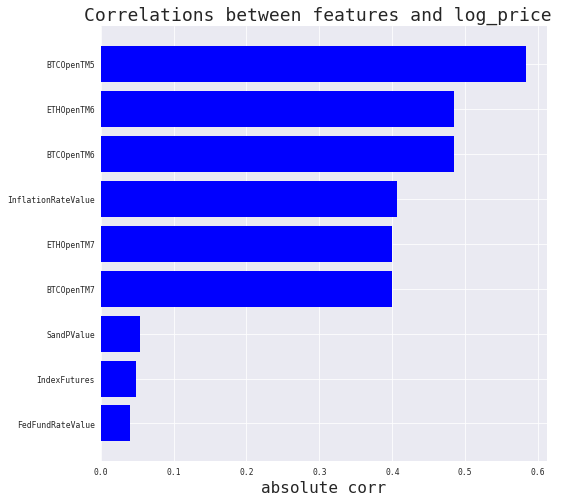

In [18]:
corr_target = corr['ETHOpen'].reset_index()[3:]
corr_target.columns = ['feature','abs_corr']
corr_target = corr_target.sort_values(by = 'abs_corr', ascending = True)[:remain_num].loc[corr_target['abs_corr'] >0.01]
ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(8,8))
rects = ax.barh(ind, corr_target.abs_corr.values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("absolute corr", fontsize = 16)
ax.set_title("Correlations between features and log_price ", fontsize = 18)
plt.show()

In [74]:
Logset = dataset

In [76]:
Logset['ETHOpen'] = np.log(Logset['ETHOpen'])
Logset['ETHHigh'] = np.log(Logset['ETHHigh'])
Logset['ETHLow'] = np.log(Logset['ETHLow'])
Logset['TBondsOpenValue'] = np.log(Logset['TBondsOpenValue'])
Logset['InflationRateValue'] = np.log(Logset['InflationRateValue'])
Logset['IndexFutures'] = np.log(Logset['IndexFutures'])
Logset['UnemploymentValue'] = np.log(Logset['UnemploymentValue'])
Logset['FedFundRateValue'] = np.log(Logset['FedFundRateValue'])
Logset['GDP'] = np.log(Logset['GDP'])
Logset['SandPValue'] = np.log(Logset['SandPValue'])
Logset['ETHOpenTM1'] = np.log(Logset['ETHOpenTM1'])
Logset['ETHOpenTM2'] = np.log(Logset['ETHOpenTM2']) 
Logset['ETHOpenTM3'] = np.log(Logset['ETHOpenTM3']) 
Logset['ETHOpenTM4'] = np.log(Logset['ETHOpenTM4']) 
Logset['ETHOpenTM5'] = np.log(Logset['ETHOpenTM5']) 
Logset['ETHOpenTM6'] = np.log(Logset['ETHOpenTM6']) 
Logset['ETHOpenTM7'] = np.log(Logset['ETHOpenTM7']) 
Logset['BTCOpenTM1'] = np.log(Logset['BTCOpenTM1']) 
Logset['BTCOpenTM2'] = np.log(Logset['BTCOpenTM2']) 
Logset['BTCOpenTM3'] = np.log(Logset['BTCOpenTM3']) 
Logset['BTCOpenTM4'] = np.log(Logset['BTCOpenTM4'])
Logset['BTCOpenTM5'] = np.log(Logset['BTCOpenTM5']) 
Logset['BTCOpenTM6'] = np.log(Logset['BTCOpenTM6'])
Logset['BTCOpenTM7'] = np.log(Logset['BTCOpenTM7'])
Logset = Logset.set_index('Date')


In [78]:
Logset.head()

,ETHOpen,ETHHigh,ETHLow,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue,...,ETHOpenTM5,ETHOpenTM6,ETHOpenTM7,BTCOpenTM1,BTCOpenTM2,BTCOpenTM3,BTCOpenTM4,BTCOpenTM5,BTCOpenTM6,BTCOpenTM7
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-31,5.431886,5.454979,5.366210,5.041407,4.576102,0.788457,1.458615,-0.186330,9.829254,7.787797,...,5.501095,5.512420,5.576933,5.431886,5.432149,5.432149,5.396804,5.501095,5.512420,5.576933
2017-05-31,5.431886,5.454979,5.366210,5.041407,4.576102,0.627007,1.458615,-0.186330,9.829254,7.787797,...,5.512420,5.576933,5.544279,5.432149,5.432149,5.396804,5.501095,5.512420,5.576933,5.544279
2017-06-01,5.432149,5.461796,5.337538,5.043223,4.572027,0.627007,1.458615,-0.094311,9.829254,7.788668,...,5.576933,5.544279,5.558410,5.432149,5.396804,5.501095,5.512420,5.576933,5.544279,5.558410
2017-06-01,5.432149,5.461796,5.337538,5.043223,4.572027,0.627007,1.481605,-0.094311,9.829254,7.788668,...,5.544279,5.558410,5.828004,5.396804,5.501095,5.512420,5.576933,5.544279,5.558410,5.828004
2017-06-02,5.396804,5.428073,5.379621,5.042820,4.574299,0.627007,1.481605,-0.094311,9.829254,7.795482,...,5.558410,5.828004,5.978025,5.501095,5.512420,5.576933,5.544279,5.558410,5.828004,5.978025


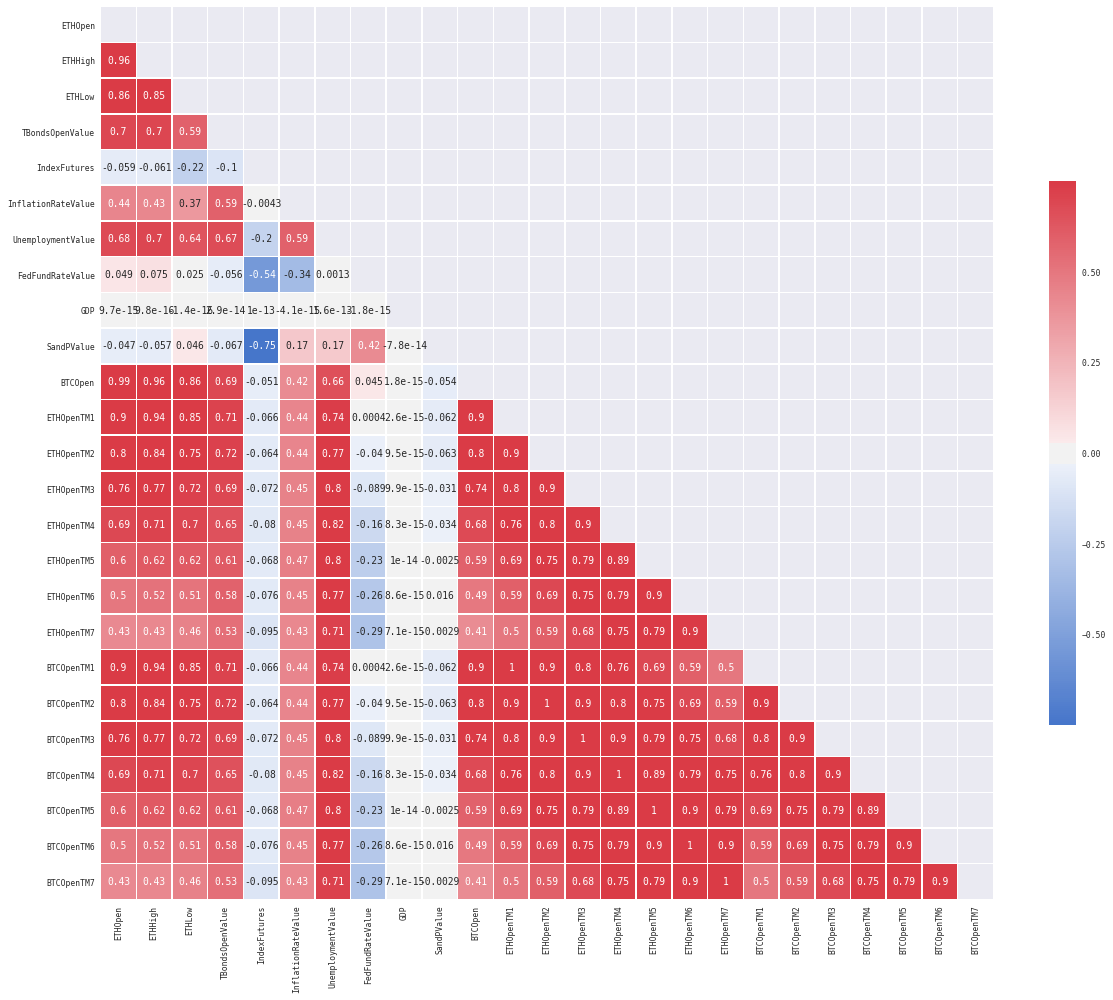

In [79]:
 
corr = Logset.corr(method='pearson')
#corrmat = np.abs(corrmat)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True



cmap = sns.diverging_palette(255, 10, as_cmap=True)

f, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,xticklabels = True, yticklabels = True, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [84]:
Logset['Date'] = Logset.index

In [82]:
Logset.to_csv('C:/Users/JP/Documents/School/Practicum/Github/Practicum/data/dataset3.csv',index=False)

In [83]:
Logset

,ETHOpen,ETHHigh,ETHLow,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue,...,ETHOpenTM6,ETHOpenTM7,BTCOpenTM1,BTCOpenTM2,BTCOpenTM3,BTCOpenTM4,BTCOpenTM5,BTCOpenTM6,BTCOpenTM7,Date
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-31,5.431886,5.454979,5.366210,5.041407,4.576102,0.788457,1.458615,-0.186330,9.829254,7.787797,...,5.512420,5.576933,5.431886,5.432149,5.432149,5.396804,5.501095,5.512420,5.576933,2017-05-31
2017-05-31,5.431886,5.454979,5.366210,5.041407,4.576102,0.627007,1.458615,-0.186330,9.829254,7.787797,...,5.576933,5.544279,5.432149,5.432149,5.396804,5.501095,5.512420,5.576933,5.544279,2017-05-31
2017-06-01,5.432149,5.461796,5.337538,5.043223,4.572027,0.627007,1.458615,-0.094311,9.829254,7.788668,...,5.544279,5.558410,5.432149,5.396804,5.501095,5.512420,5.576933,5.544279,5.558410,2017-06-01
2017-06-01,5.432149,5.461796,5.337538,5.043223,4.572027,0.627007,1.481605,-0.094311,9.829254,7.788668,...,5.558410,5.828004,5.396804,5.501095,5.512420,5.576933,5.544279,5.558410,5.828004,2017-06-01
2017-06-02,5.396804,5.428073,5.379621,5.042820,4.574299,0.627007,1.481605,-0.094311,9.829254,7.795482,...,5.828004,5.978025,5.501095,5.512420,5.576933,5.544279,5.558410,5.828004,5.978025,2017-06-02
2017-06-05,5.501095,5.515926,5.486869,5.051657,4.569232,0.627007,1.481605,-0.094311,9.829254,7.797291,...,5.978025,5.961237,5.512420,5.576933,5.544279,5.558410,5.828004,5.978025,5.961237,2017-06-05
2017-06-06,5.512420,5.591435,5.507362,5.047851,4.569906,0.627007,1.481605,-0.094311,9.829254,7.796880,...,5.961237,5.840176,5.576933,5.544279,5.558410,5.828004,5.978025,5.961237,5.840176,2017-06-06
2017-06-07,5.576933,5.578975,5.506022,5.052257,4.567624,0.627007,1.481605,-0.094311,9.829254,7.796428,...,5.840176,5.842616,5.544279,5.558410,5.828004,5.978025,5.961237,5.840176,5.842616,2017-06-07
2017-06-08,5.544279,5.563639,5.525015,5.048252,4.569077,0.627007,1.481605,-0.094311,9.829254,7.796223,...,5.842616,5.862295,5.558410,5.828004,5.978025,5.961237,5.840176,5.842616,5.862295,2017-06-08
